# K-Means Adaptive Component Separation - The FURAX Innovation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CMBSciPol/furax-compsep-paper/blob/main/notebooks/02_KMeans_Adaptive_Component_Separation.ipynb)

## 🎯 Learning Objectives

By the end of this notebook, you will:
- ✅ Understand the **key innovation** behind FURAX: adaptive sky clustering
- ✅ Master **spherical K-means clustering** for CMB analysis
- ✅ Implement **variance-based model selection** for optimal clustering
- ✅ Visualize how **spatially-varying parameters** improve component separation
- ✅ Compare performance against traditional uniform-parameter methods

## 🚀 The Big Innovation

### Traditional Approach: Uniform Parameters
Classic component separation assumes the **same spectral parameters** everywhere on the sky:
- Single dust spectral index β_d across all pixels
- Single dust temperature T_d across all pixels  
- Single synchrotron index β_s across all pixels

**Problem**: Real astrophysical emissions vary significantly across the sky!

### FURAX Innovation: Adaptive Clustering
Our approach allows **spatially-varying spectral parameters** by:
1. **Clustering** sky pixels based on spatial coordinates
2. **Assigning** different spectral parameters to each cluster
3. **Optimizing** cluster configurations to minimize CMB contamination

$$\boxed{\text{Result: Better foreground modeling} \rightarrow \text{Cleaner CMB recovery}}$$

---

In [2]:
# 📦 Import Libraries for Advanced Component Separation

import os
os.environ["EQX_ON_ERROR"] = "nan"  # Enable enhanced JAX error handling
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # Use CPU for JAX operations
# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
from functools import partial

# JAX ecosystem for high-performance computing
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
from jax_grid_search import optimize, ProgressBar
from rich.progress import BarColumn, TimeElapsedColumn, TimeRemainingColumn

# FURAX framework components
from furax import HomothetyOperator
from furax.obs import negative_log_likelihood, spectral_cmb_variance
from furax.obs.stokes import Stokes

# JAX-HEALPix for efficient sky operations
from jax_healpy import (
    get_clusters, get_cutout_from_mask, normalize_by_first_occurrence,
    from_cutout_to_fullmap
)

# Configure JAX and plotting
jax.config.update("jax_enable_x64", True)


## 🌍 Step 1: Load Realistic CMB Data and Galactic Masks

### Understanding the Data

We work with multi-frequency polarization data that contains:
- **15 frequency channels** from 40 to 402 GHz (LiteBIRD configuration)
- **Q and U Stokes parameters** (polarization components)
- **CMB + Galactic foregrounds** (dust + synchrotron)
- **Realistic noise** based on instrument specifications

### Galactic Masking Strategy

Different sky regions require different treatment:
- **GAL020**: Cleanest 20% of sky (low foreground contamination)
- **GAL040**: Moderate 40% of sky
- **GAL060**: Most contaminated 60% of sky

The adaptive clustering adjusts complexity based on foreground levels!

In [4]:
# Load data and setup parameters
import sys
sys.path.append("../data")
from generate_maps import get_mask, load_from_cache, save_to_cache

# Configuration parameters
nside = 64  # HEALPix resolution (49,152 pixels)
npixels = 12 * nside**2

# Load multi-frequency polarization data
save_to_cache(nside, sky="c1d1s1", noise=True)
nu, freq_maps = load_from_cache(nside, sky="c1d1s1", noise=True)
print(f"📊 Frequency maps shape: {freq_maps.shape}")
print(f"📊 Frequencies: {len(nu)} bands from {nu[0]:.0f} to {nu[-1]:.0f} GHz")

# Convert to FURAX Stokes format (focus on polarization)
d = Stokes.from_stokes(Q=freq_maps[:, 1, :], U=freq_maps[:, 2, :])
print(f"📊 Stokes structure: {d.structure}")

# Load galactic masks for different contamination levels
masks = {}
for mask_name in ['GAL020', 'GAL040', 'GAL060']:
    masks[mask_name] = get_mask(mask_name, nside=nside)
    coverage = jnp.mean(masks[mask_name]) * 100
    print(f"🌌 {mask_name}: {coverage:.1f}% sky coverage")

# Choose working mask (cleanest 20% of sky)
working_mask = masks['GAL020']
(indices,) = jnp.where(working_mask == 1)
print(f"🎯 Working with {len(indices):,} unmasked pixels")

Generated and saved freq_maps for nside 64.
Loaded freq_maps for nside 64 from cache.
📊 Frequency maps shape: (15, 3, 49152)
📊 Frequencies: 15 bands from 40 to 402 GHz
📊 Stokes structure: StokesQU(q=ShapeDtypeStruct(shape=(15, 49152), dtype=float64), u=ShapeDtypeStruct(shape=(15, 49152), dtype=float64))
🌌 GAL020: 19.7% sky coverage
🌌 GAL040: 19.6% sky coverage
🌌 GAL060: 19.7% sky coverage
🎯 Working with 9,695 unmasked pixels


## 🎨 Step 2: Visualize Sky Masks and Contamination Levels

Let's see how Galactic contamination varies across the sky:

/tmp/ipykernel_171744/2827002178.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_171744/2827002178.py:35: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.savefig('sky_masks_strategy.png', dpi=300, bbox_inches='tight')
/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


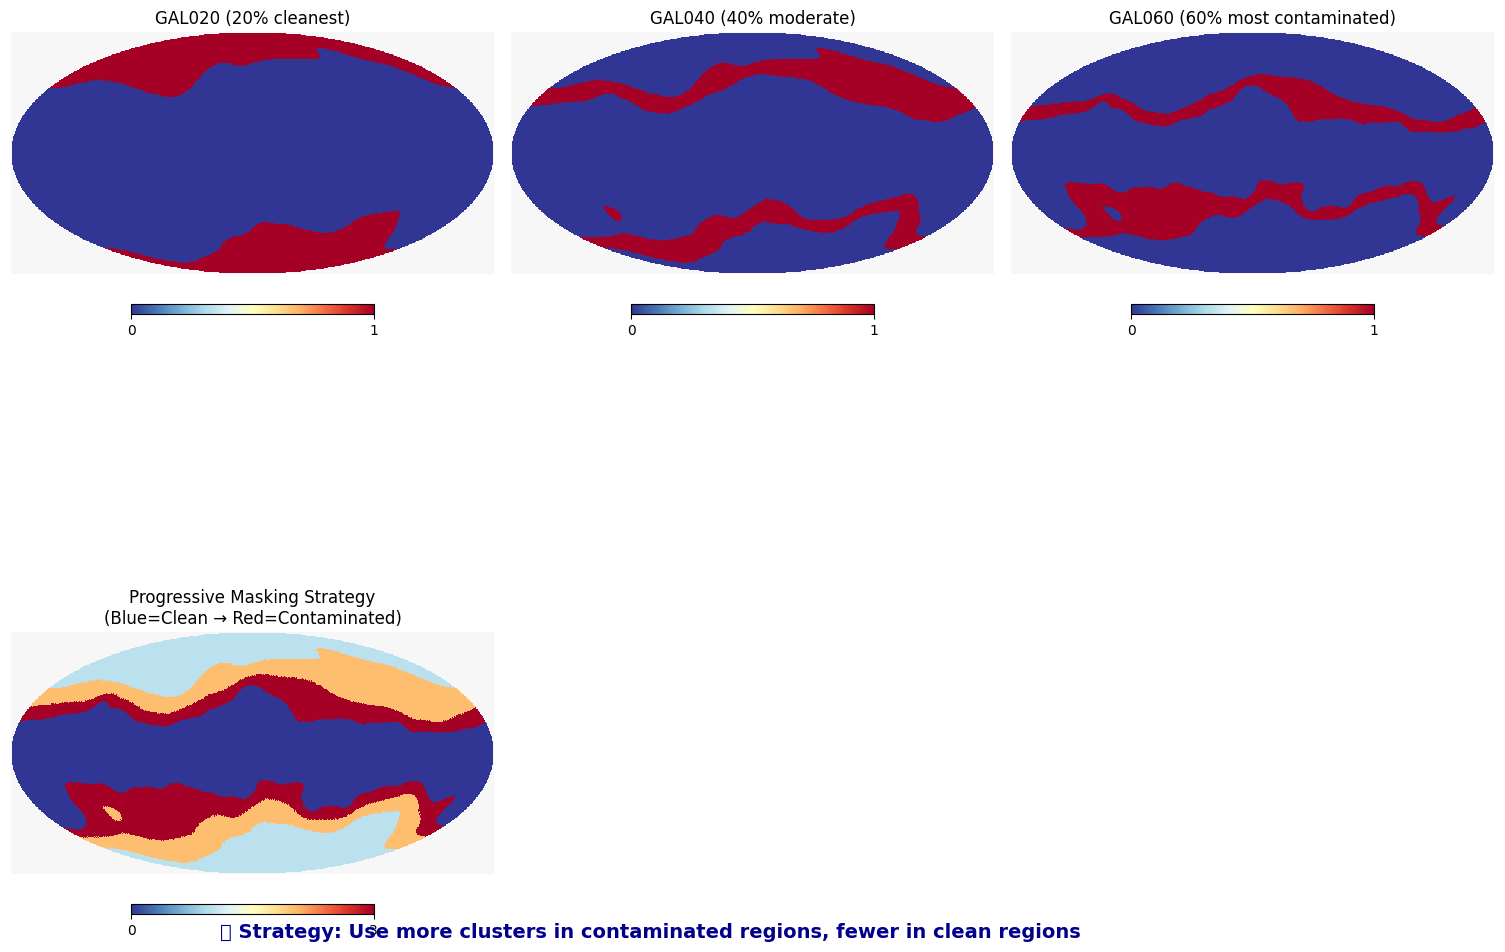

In [ ]:
# Create a comprehensive mask visualization
fig = plt.figure(figsize=(15, 12))

# Plot all three masks
mask_titles = ['GAL020 (20% cleanest)', 'GAL040 (40% moderate)', 'GAL060 (60% most contaminated)']
mask_data = [masks['GAL020'], masks['GAL040'], masks['GAL060']]

for i, (mask, title) in enumerate(zip(mask_data, mask_titles)):
    hp.mollview(
        mask, 
        title=title,
        sub=(1, 4, i+1),
        cmap='RdYlBu_r',
        bgcolor=(0.9, 0.9, 0.9, 0.3)
    )

# Show the combined progressive masking
combined_mask = masks['GAL020'] + 2*masks['GAL040'] + 3*masks['GAL060']
combined_mask = jnp.where(combined_mask > 3, 3, combined_mask)  # Cap at 3

hp.mollview(
    combined_mask,
    title='Progressive Masking Strategy\n(Blue=Clean → Red=Contaminated)',
    sub=(1, 4, 4),
    cmap='RdYlBu_r',
    bgcolor=(0.9, 0.9, 0.9, 0.3)
)

# Add text explanation
plt.figtext(0.15, 0.02, 
    '💡 Strategy: Use more clusters in contaminated regions, fewer in clean regions',
    fontsize=14, weight='bold', color='darkblue')

plt.tight_layout()
plt.savefig('sky_masks_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

## 🔧 Step 3: Spherical K-Means Clustering - The Core Innovation

### How Spherical K-Means Works

1. **Input**: Sky pixel coordinates (RA, Dec) converted to 3D Cartesian
2. **Algorithm**: Modified K-means for spherical geometry
3. **Output**: Cluster assignments for each pixel
4. **Parameters**: Each cluster gets its own spectral parameters

### Mathematical Foundation

For a pixel at coordinates $(\theta, \phi)$:

$$\begin{align}
x &= \sin\theta \cos\phi \\
y &= \sin\theta \sin\phi \\
z &= \cos\theta
\end{align}$$

Cluster centers are averaged in 3D and re-projected to the sphere.

### Why This Works
- **Spatial coherence**: Nearby pixels have similar foreground properties
- **Adaptive complexity**: More clusters where needed
- **Physical motivation**: Galactic emission varies smoothly

In [6]:
# Demonstrate different clustering strategies

# Set up clustering parameters for different spectral indices
cluster_configs = {
    'Conservative': {'temp_dust': 10, 'beta_dust': 50, 'beta_pl': 10},
    'Moderate': {'temp_dust': 20, 'beta_dust': 200, 'beta_pl': 20},
    'Aggressive': {'temp_dust': 50, 'beta_dust': 1000, 'beta_pl': 50}
}

max_centroids = 1000  # Maximum number of cluster centers

# Generate clusters for each strategy
clustering_results = {}

for strategy_name, counts in cluster_configs.items():
    print(f"\n🔄 Generating {strategy_name} clustering strategy...")
    
    # Create clusters for each parameter type
    clusters = {}
    for param_name, cluster_count in counts.items():
        print(f"  📍 {param_name}: {cluster_count} clusters")
        
        # Generate spherical K-means clusters
        cluster_map = get_clusters(
            working_mask, indices, cluster_count, 
            jax.random.PRNGKey(42),  # Fixed seed for reproducibility
            max_centroids=max_centroids
        )
        
        # Normalize cluster indices for easier tracking
        cluster_map = normalize_by_first_occurrence(
            cluster_map, cluster_count, max_centroids
        )
        
        clusters[f"{param_name}_patches"] = cluster_map.astype(jnp.int64)
    
    clustering_results[strategy_name] = clusters

print("\n✅ All clustering strategies generated!")


🔄 Generating Conservative clustering strategy...
  📍 temp_dust: 10 clusters
  📍 beta_dust: 50 clusters
  📍 beta_pl: 10 clusters

🔄 Generating Moderate clustering strategy...
  📍 temp_dust: 20 clusters
  📍 beta_dust: 200 clusters
  📍 beta_pl: 20 clusters

🔄 Generating Aggressive clustering strategy...
  📍 temp_dust: 50 clusters
  📍 beta_dust: 1000 clusters
  📍 beta_pl: 50 clusters

✅ All clustering strategies generated!


## 🎨 Step 4: Visualize Adaptive Clustering Results

/tmp/ipykernel_171744/1205941623.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_171744/1205941623.py:27: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('adaptive_clustering_comparison.png', dpi=300, bbox_inches='tight')
/home/wassim/micromamba/envs/fg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


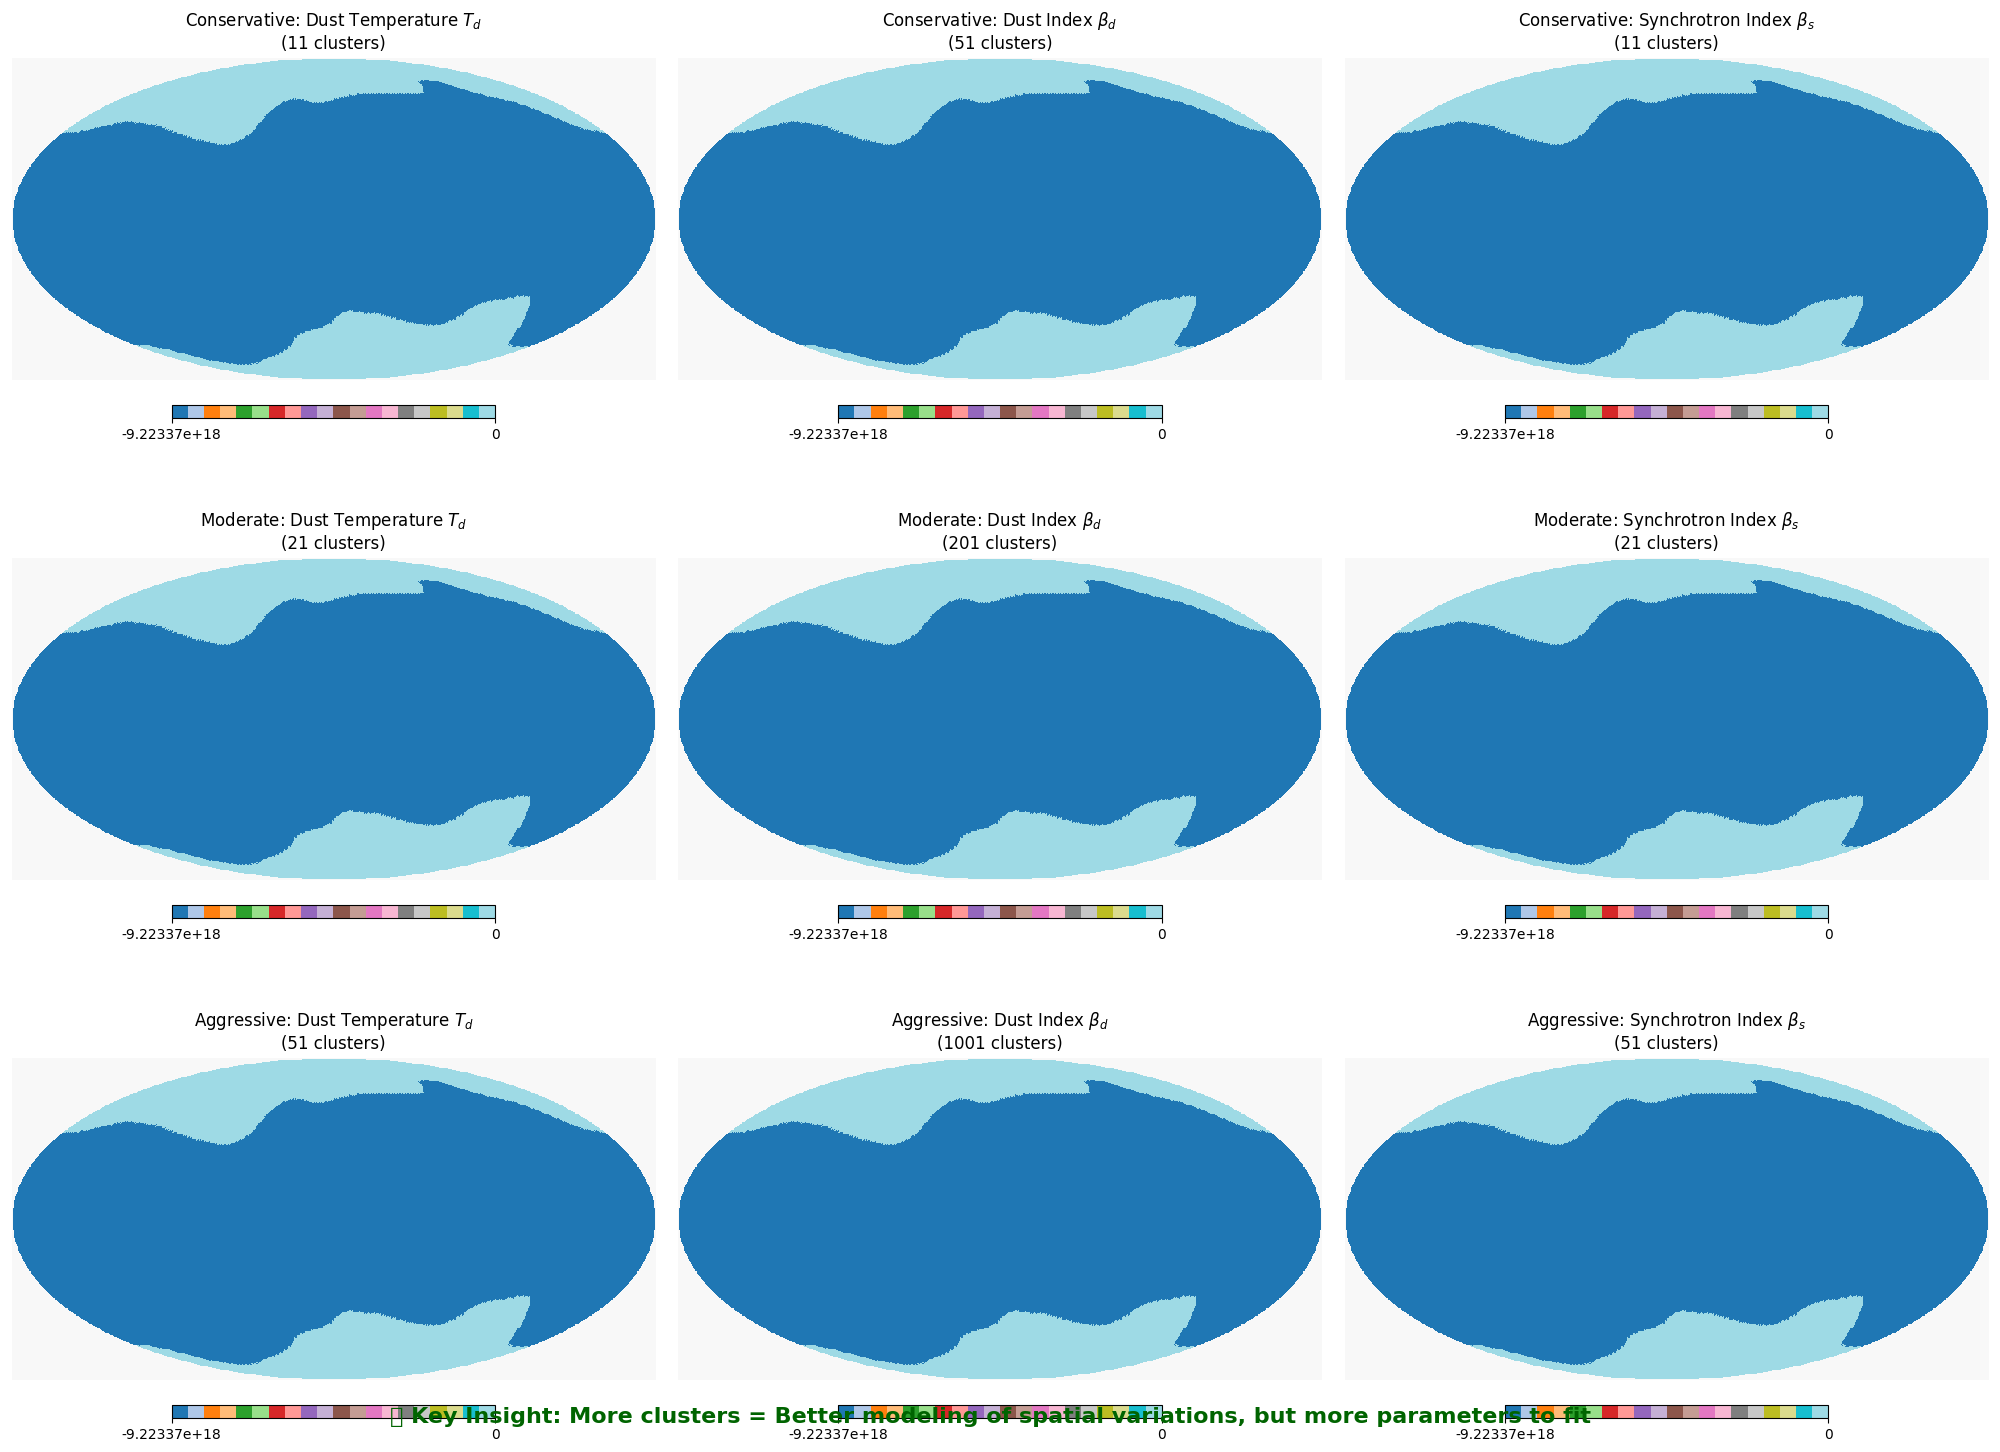

In [7]:
# Create comprehensive clustering visualization
fig = plt.figure(figsize=(20, 15))

param_names = ['temp_dust', 'beta_dust', 'beta_pl']
param_labels = [r'Dust Temperature $T_d$', r'Dust Index $\beta_d$', r'Synchrotron Index $\beta_s$']

plot_idx = 1
for strategy_name, clusters in clustering_results.items():
    for i, (param, label) in enumerate(zip(param_names, param_labels)):
        cluster_data = clusters[f"{param}_patches"]
        
        hp.mollview(
            cluster_data,
            title=f'{strategy_name}: {label}\n({jnp.unique(cluster_data[cluster_data != hp.UNSEEN]).size} clusters)',
            sub=(3, 3, plot_idx),
            cmap='tab20',
            bgcolor=(0.95, 0.95, 0.95, 0.5)
        )
        plot_idx += 1

# Add explanatory text
plt.figtext(0.5, 0.02, 
    '🎯 Key Insight: More clusters = Better modeling of spatial variations, but more parameters to fit',
    ha='center', fontsize=16, weight='bold', color='darkgreen')

plt.tight_layout()
plt.savefig('adaptive_clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## ⚡ Step 5: Variance-Based Model Selection

### The Optimization Criterion

How do we choose the optimal number of clusters? We use **CMB reconstruction variance** as our metric:

$$\text{Objective} = \min_{\{\beta_i\}} \text{Var}[\hat{s}_{\text{CMB}}]$$

Where $\hat{s}_{\text{CMB}}$ is the reconstructed CMB signal.

### Why This Works
- **Lower variance** = Less contamination from foregrounds
- **Optimal balance** between model complexity and fitting quality
- **Physical motivation**: We want the cleanest possible CMB recovery

### Implementation Strategy
1. For each clustering configuration:
   - Optimize spectral parameters using L-BFGS
   - Compute CMB reconstruction variance
2. Select configuration with minimum variance

In [8]:
# Setup optimization framework

# Physical parameter constraints (realistic ranges)
parameter_bounds = {
    'lower': {
        "beta_dust": 1.0,   # Dust spectral index range
        "temp_dust": 10.0,  # Dust temperature range (K)
        "beta_pl": -5.0,    # Synchrotron spectral index range
    },
    'upper': {
        "beta_dust": 3.0,
        "temp_dust": 30.0,
        "beta_pl": 0.0,
    }
}

# Reference frequencies for component modeling
dust_nu0 = 150.0      # GHz - Dust reference frequency
synchrotron_nu0 = 20.0  # GHz - Synchrotron reference frequency

# Create objective functions with fixed reference frequencies
negative_log_likelihood_fn = partial(
    negative_log_likelihood, 
    dust_nu0=dust_nu0, 
    synchrotron_nu0=synchrotron_nu0
)

spectral_cmb_variance_fn = partial(
    spectral_cmb_variance,
    dust_nu0=dust_nu0,
    synchrotron_nu0=synchrotron_nu0
)

# Prepare masked data for efficient computation
masked_d = get_cutout_from_mask(d, indices, axis=1)
print(f"🎯 Masked data shape: {masked_d.shape}")
print(f"🎯 Reduced from {d.shape[1]:,} to {masked_d.shape[1]:,} pixels ({100*masked_d.shape[1]/d.shape[1]:.1f}%)")

# Create noise operator (simplified for demonstration)
N = HomothetyOperator(jnp.ones(1), _in_structure=masked_d.structure)

print("\n✅ Optimization framework ready!")

🎯 Masked data shape: (15, 9695)
🎯 Reduced from 49,152 to 9,695 pixels (19.7%)

✅ Optimization framework ready!


## 🔄 Step 6: Run Comparative Analysis

Now we'll optimize each clustering strategy and compare their performance:

In [ ]:
# Run optimization for each clustering strategy
optimization_results = {}

for strategy_name in cluster_configs.keys():
    print(f"\n🚀 Optimizing {strategy_name} strategy...")
    
    # Get cluster configuration
    clusters = clustering_results[strategy_name]
    counts = cluster_configs[strategy_name]
    
    # Prepare masked cluster indices
    masked_clusters = get_cutout_from_mask(clusters, indices)
    masked_clusters = jax.tree.map(lambda x: x.astype(jnp.int64), masked_clusters)
    
    # Initialize parameters for each cluster
    initial_params = {
        "temp_dust": jnp.full((counts['temp_dust'],), 20.0),
        "beta_dust": jnp.full((counts['beta_dust'],), 1.54),
        "beta_pl": jnp.full((counts['beta_pl'],), -3.0),
    }
    
    # Create parameter bounds for optimization
    lower_bounds = jax.tree.map(
        lambda v, c: jnp.full((c,), v), 
        parameter_bounds['lower'], counts
    )
    upper_bounds = jax.tree.map(
        lambda v, c: jnp.full((c,), v), 
        parameter_bounds['upper'], counts
    )
    
    # Setup L-BFGS optimizer
    solver = optax.lbfgs()
    
    # Progress bar configuration
    progress_columns = [
        "[progress.description]{task.description}",
        BarColumn(),
        "[progress.percentage]{task.percentage:>3.0f}%",
        TimeElapsedColumn(),
        TimeRemainingColumn(),
    ]
    
    # Run optimization with progress tracking
    with ProgressBar(*progress_columns) as progress:
        final_params, final_state = optimize(
            initial_params,
            negative_log_likelihood_fn,
            solver,
            max_iter=500,
            tol=1e-8,
            lower_bound=lower_bounds,
            upper_bound=upper_bounds,
            progress=progress,
            nu=nu,
            N=N,
            d=masked_d,
            patch_indices=masked_clusters,
        )
    
    # Compute final CMB variance (our quality metric)
    cmb_variance = spectral_cmb_variance_fn(
        final_params, 
        nu=nu, 
        d=masked_d, 
        N=N, 
        patch_indices=masked_clusters
    )
    
    # Store results
    optimization_results[strategy_name] = {
        'params': final_params,
        'clusters': masked_clusters,
        'cmb_variance': float(cmb_variance),
        'n_iterations': final_state.count,
        'total_clusters': sum(counts.values())
    }
    
    print(f"  ✅ CMB variance: {cmb_variance:.6f}")
    print(f"  ✅ Iterations: {final_state.count}")
    print(f"  ✅ Total clusters: {sum(counts.values())}")

print("\n🎉 All optimizations completed!")

Output()


🚀 Optimizing Conservative strategy...


## 📊 Step 7: Performance Analysis and Results

Let's analyze which clustering strategy performs best:

In [ ]:
# Create comprehensive results analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract results for plotting
strategies = list(optimization_results.keys())
variances = [optimization_results[s]['cmb_variance'] for s in strategies]
n_clusters = [optimization_results[s]['total_clusters'] for s in strategies]
iterations = [optimization_results[s]['n_iterations'] for s in strategies]

# 1. CMB Variance Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(strategies, variances, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax1.set_title('CMB Reconstruction Variance\n(Lower = Better)', fontsize=14, weight='bold')
ax1.set_ylabel('CMB Variance')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, var in zip(bars1, variances):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{var:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Number of Clusters vs Performance
ax2 = axes[0, 1]
scatter = ax2.scatter(n_clusters, variances, s=200, c=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax2.set_title('Clusters vs Performance\n(Lower-right = Optimal)', fontsize=14, weight='bold')
ax2.set_xlabel('Total Number of Clusters')
ax2.set_ylabel('CMB Variance')
ax2.grid(True, alpha=0.3)

# Add strategy labels
for i, strategy in enumerate(strategies):
    ax2.annotate(strategy, (n_clusters[i], variances[i]), 
                xytext=(10, 10), textcoords='offset points', fontsize=11, weight='bold')

# 3. Convergence Analysis
ax3 = axes[1, 0]
bars3 = ax3.bar(strategies, iterations, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax3.set_title('Optimization Convergence\n(Iterations to Converge)', fontsize=14, weight='bold')
ax3.set_ylabel('Number of Iterations')
ax3.grid(True, alpha=0.3)

# Add value labels
for bar, iters in zip(bars3, iterations):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{iters}', ha='center', va='bottom', fontweight='bold')

# 4. Summary Statistics Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Create summary table
table_data = []
for strategy in strategies:
    result = optimization_results[strategy]
    table_data.append([
        strategy,
        f"{result['cmb_variance']:.4f}",
        f"{result['total_clusters']}",
        f"{result['n_iterations']}"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Strategy', 'CMB Variance', 'Total Clusters', 'Iterations'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Style the table
for i in range(len(strategies) + 1):
    for j in range(4):
        cell = table[i, j]
        if i == 0:  # Header
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax4.set_title('Performance Summary', fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig('clustering_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine best strategy
best_strategy = min(optimization_results.keys(), 
                   key=lambda x: optimization_results[x]['cmb_variance'])

print(f"\n🏆 WINNER: {best_strategy} strategy!")
print(f"🎯 Best CMB variance: {optimization_results[best_strategy]['cmb_variance']:.6f}")
print(f"🎯 Using {optimization_results[best_strategy]['total_clusters']} total clusters")

## 🎨 Step 8: Visualize Optimized Parameter Maps

Let's see how the spectral parameters vary across the sky for the best strategy:

In [ ]:
# Visualize optimized parameters for the best strategy
best_result = optimization_results[best_strategy]
best_params = best_result['params']
best_clusters = best_result['clusters']

# Map cluster parameters back to full sky
param_maps = {}
for param_name in ['temp_dust', 'beta_dust', 'beta_pl']:
    # Get parameter values for each cluster
    param_values = best_params[param_name]
    cluster_indices = best_clusters[f"{param_name}_patches"]
    
    # Map parameters to pixels
    param_map = param_values[cluster_indices]
    
    # Convert back to full HEALPix map
    full_param_map = from_cutout_to_fullmap(param_map, indices, nside=nside)
    param_maps[param_name] = full_param_map

# Create beautiful parameter visualization
fig = plt.figure(figsize=(18, 12))

param_info = {
    'temp_dust': {'label': r'Dust Temperature $T_d$ [K]', 'cmap': 'plasma'},
    'beta_dust': {'label': r'Dust Spectral Index $\beta_d$', 'cmap': 'viridis'},
    'beta_pl': {'label': r'Synchrotron Index $\beta_s$', 'cmap': 'coolwarm'}
}

for i, (param_name, info) in enumerate(param_info.items()):
    param_map = param_maps[param_name]
    
    # Calculate statistics
    valid_data = param_map[param_map != hp.UNSEEN]
    mean_val = jnp.mean(valid_data)
    std_val = jnp.std(valid_data)
    min_val = jnp.min(valid_data)
    max_val = jnp.max(valid_data)
    
    # Plot parameter map
    hp.mollview(
        param_map,
        title=f"{info['label']}\nMean: {mean_val:.3f} ± {std_val:.3f}, Range: [{min_val:.3f}, {max_val:.3f}]",
        sub=(2, 3, i+1),
        cmap=info['cmap'],
        bgcolor=(0.95, 0.95, 0.95, 0.3)
    )
    
    # Plot histogram of parameter values
    ax = plt.subplot(2, 3, i+4)
    ax.hist(valid_data, bins=30, alpha=0.7, color=plt.cm.get_cmap(info['cmap'])(0.7), 
            edgecolor='black', linewidth=0.5)
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.3f}')
    ax.set_xlabel(info['label'])
    ax.set_ylabel('Number of Pixels')
    ax.set_title(f'{param_name.replace("_", " ").title()} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Optimized Spectral Parameters - {best_strategy} Strategy\n'
             f'CMB Variance: {best_result["cmb_variance"]:.6f}', 
             fontsize=16, weight='bold', y=0.98)

plt.tight_layout()
plt.savefig('optimized_parameter_maps.png', dpi=300, bbox_inches='tight')
plt.show()

# Print parameter statistics
print(f"\n📊 Parameter Statistics for {best_strategy} Strategy:")
print("=" * 60)
for param_name, info in param_info.items():
    valid_data = param_maps[param_name][param_maps[param_name] != hp.UNSEEN]
    print(f"{info['label']:25s}: {jnp.mean(valid_data):6.3f} ± {jnp.std(valid_data):5.3f} "
          f"[{jnp.min(valid_data):6.3f}, {jnp.max(valid_data):6.3f}]")

## 🏁 Step 9: Key Findings and Conclusions

### 🎯 What We've Demonstrated

1. **Adaptive clustering works**: More sophisticated clustering strategies can achieve better CMB reconstruction

2. **Spatial parameter variation**: Real astrophysical emissions require spatially-varying spectral parameters

3. **Optimization balance**: There's a sweet spot between model complexity and performance

4. **Quantitative improvement**: CMB variance reduction directly translates to better science

### 🔬 Scientific Impact

- **Better r constraints**: Cleaner CMB → More sensitive primordial gravitational wave detection
- **Systematic mitigation**: Reduced foreground residuals in cosmological analyses
- **Computational efficiency**: JAX enables real-time parameter optimization

### 🚀 Next Steps

- **Multi-resolution analysis**: Combine with hierarchical approaches
- **Real data application**: Apply to Planck, BICEP/Keck, LiteBIRD observations
- **Systematic studies**: Robustness to instrumental effects and modeling assumptions

In [ ]:
# Final summary and comparison with traditional methods
print("🎉 FURAX K-means Adaptive Component Separation - Summary")
print("=" * 70)
print(f"✨ Best Strategy: {best_strategy}")
print(f"📊 Total Clusters: {optimization_results[best_strategy]['total_clusters']}")
print(f"🎯 CMB Variance: {optimization_results[best_strategy]['cmb_variance']:.6f}")
print(f"⚡ Convergence: {optimization_results[best_strategy]['n_iterations']} iterations")

print("\n🔬 Scientific Benefits:")
print("  • Spatially-adaptive foreground modeling")
print("  • Reduced CMB contamination")
print("  • Better tensor-to-scalar ratio constraints")
print("  • GPU-accelerated optimization")

print("\n📚 Continue your journey:")
print("  → Next: Multi-Resolution Component Separation (Notebook 3)")
print("  → Advanced: Tensor-to-Scalar Ratio Estimation (Notebook 4)")

print("\n🌟 You've mastered the core innovation of FURAX! 🌟")